# Assay Targets
This notebook explores the target data for a given set of assays from PubChem. 

Run `pubchem_target_summaries.py` BEFORE using this notebook to get the required input file (assay ids with annotation info).

In [1]:
# run pubchem_target_summaries.py to generate this file
TARGETS_JSON_FILE = "/media/jack/big_disk/data/badapple/aid2target_tested.json"

## Setup

In [2]:
import json
import requests
import os

from collections import Counter

from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def load_json_file(json_file: str):
    with open(json_file, "r") as f:
        data = json.load(f)
    return data

In [4]:
target_data = load_json_file(TARGETS_JSON_FILE)

## Visualize Basic Info
Frequency plot for targets, grouped by three basic categories:
1) Protein
2) Non-Protein
3) UNSPECIFIED (meaning no target info was available from PubChem)

In [5]:
def get_frequency_df(l: list[str]) -> pd.DataFrame:
    term_counts = Counter(l)
    df = pd.DataFrame(term_counts.items(), columns=['Term', 'Frequency'])
    df = df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)
    return df

In [6]:
def get_high_frequency_df(df: pd.DataFrame, thresh: int) -> pd.DataFrame:
    # group terms with frequencies <= thresh under "Other" category
    df_high_freq = df[df['Frequency'] > thresh]
    other_freq_sum = df[df['Frequency'] <= thresh]['Frequency'].sum()
    i = len(df_high_freq)
    df_high_freq.loc[i] = ['OTHER', other_freq_sum]
    df_high_freq = df_high_freq.sort_values(by='Frequency', ascending=False).reset_index(drop=True)
    return df_high_freq

In [7]:
def plot_term_counts(frequency_df: pd.DataFrame, key: str):
    n_total = sum(frequency_df['Frequency'])

    plt.figure(figsize=(10, 6))
    plt.bar(frequency_df['Term'], frequency_df['Frequency'], color='skyblue')

    plt.xlabel('Terms')
    plt.ylabel('Frequency')
    plt.yscale('log')
    plt.title(f'Frequency of {key} Terms, N={n_total}')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

In [8]:
def is_protein(target: dict):
    return "protein_accession" in target

In [9]:
simple_terms = []
for aid, target_list in target_data.items():
        if target_list is not None: # some AIDs have no target information
            for target in target_list:
                if is_protein(target):
                    simple_terms.append("Protein")
                else:
                     simple_terms.append("Non-Protein")
        else:
              simple_terms.append("UNSPECIFIED")

In [10]:
simple_term_freq_df = get_frequency_df(simple_terms)
simple_term_freq_df # note that sum(frequencies) can be > assay count since some assays list multiple targets

,Term,Frequency
0,Protein,723
1,UNSPECIFIED,161
2,Non-Protein,9


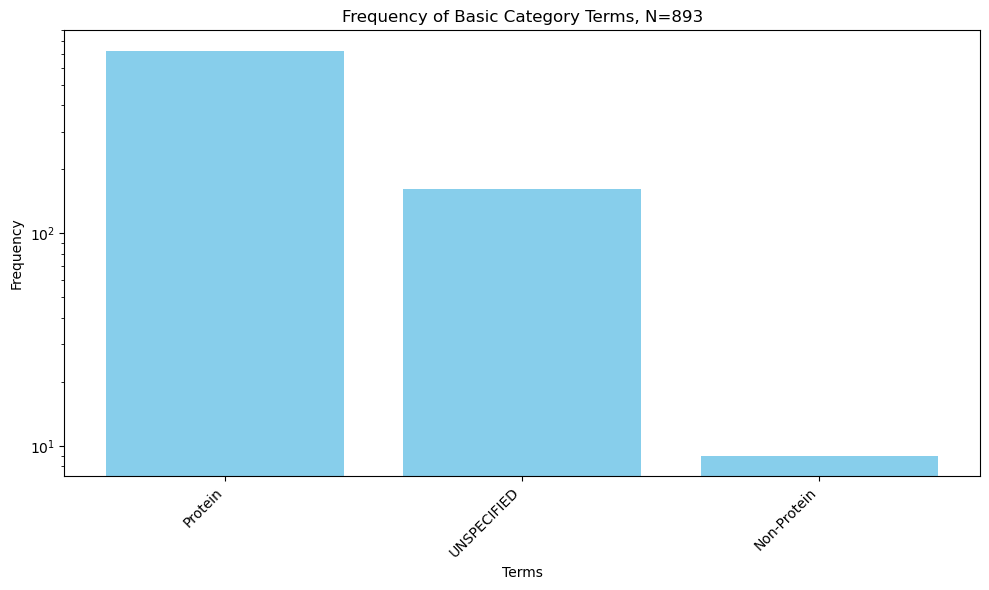

In [11]:
plot_term_counts(simple_term_freq_df, "Basic Category")

## Protein Families (from Pharos)
Visualize the frequency of protein families for all protein targets which have a UniProt ID. 

In [12]:
def get_protein_family(uniprot_id: str):
    # get the protein family from pharos using GraphQL api
    api_url = "https://pharos-api.ncats.io/graphql"
    query_str = f"""
        query targetDetails {{
        target(q: {{uniprot: "{uniprot_id}"}}) {{
            fam
        }}
        }}
        """
    response = requests.post(api_url, json={'query': query_str})
    family = None
    if response.status_code == 200:
        data = response.json()
        if data['data']['target'] is not None:
            family = data['data']['target']['fam']
    else:
        print(f"Failed to fetch data for uniprot_id: {uniprot_id}. Error: {response.status_code}")
    return family

In [13]:
def create_protein_family_json_file(json_file: str):
    uniprot2fam = {}
    for aid, target_list in tqdm(target_data.items(), "Getting protein target families..."):
        if target_list is not None: # some AIDs have no target information
            for target in target_list:
                uniprot_id =  target.get('uniprot_id', None)
                if uniprot_id is not None:
                    uniprot2fam[uniprot_id] = get_protein_family(uniprot_id)
    with open(json_file, "w") as f:
        json.dump(uniprot2fam, f, indent=4)

In [14]:
# will want to cache JSON file to avoid re-running requests
data_dir = os.path.dirname(TARGETS_JSON_FILE)
PHAROS_FAMILIES_JSON = os.path.join(data_dir, "uniprot2family_tested.json")

In [15]:
if not os.path.exists(PHAROS_FAMILIES_JSON):
    create_protein_family_json_file(PHAROS_FAMILIES_JSON)

In [16]:
protein_families_dict = load_json_file(PHAROS_FAMILIES_JSON)
# map None to "NULL" value for plotting purposes
# here None means the target is a protein w/ a uniprot id, but the uniprot id is not in pharos
protein_families = list(map(lambda x: "NULL" if x is None else x, protein_families_dict.values()))

In [17]:
family_freq_df = get_frequency_df(protein_families)
family_freq_df

,Term,Frequency
0,NULL,175
1,Enzyme,82
2,GPCR,43
3,Kinase,25
4,NR,12
5,TF,12
6,Epigenetic,10
7,IC,10
8,Transporter,5
9,TF; Epigenetic,2


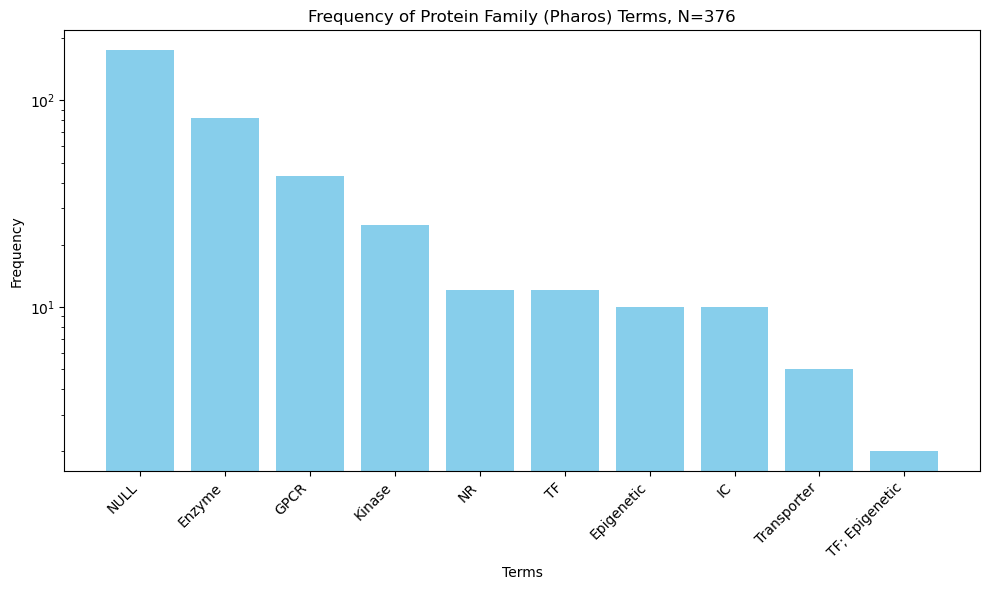

In [18]:
plot_term_counts(family_freq_df, "Protein Family (Pharos)")

## Target Organisms

In [19]:
def get_taxname(target: dict):
    if "organism" in target:
        if "org" in target["organism"]:
            return target["organism"]["org"].get("taxname", "NULL")
    return "NULL"

In [20]:
organism_taxnames = []
for aid, target_list in target_data.items():
        if target_list is not None: # some AIDs have no target information
            for target in target_list:
                taxname = get_taxname(target)
                organism_taxnames.append(taxname)

In [21]:
taxname_freq_df = get_frequency_df(organism_taxnames)

In [22]:
# view organisms which appear more than once
taxname_freq_df[taxname_freq_df['Frequency'] > 1]

,Term,Frequency
0,Homo sapiens,532
1,Mus musculus,31
2,NULL,23
3,Rattus norvegicus,13
4,Saccharomyces cerevisiae,7
5,Mycobacterium tuberculosis H37Rv,7
6,Escherichia coli,6
7,Human immunodeficiency virus 1,6
8,Escherichia coli str. K-12 substr. MG1655,6
9,Bos taurus,6


In [23]:
# organisms which appear only once
taxname_freq_df[taxname_freq_df['Frequency'] <= 1]

,Term,Frequency
34,Infectious bronchitis virus,1
35,Clostridium botulinum A str. ATCC 3502,1
36,Yersinia pestis CO92,1
37,Lake Victoria marburgvirus,1
38,Photuris pennsylvanica,1
39,Clostridium botulinum Bf,1
40,Dengue virus 2 16681-PDK53,1
41,Influenza A virus (A/California/07/2009(H1N1)),1
42,Staphylococcus aureus subsp. aureus N315,1
43,Mycobacterium tuberculosis UT205,1


In [24]:
# for the sake of plotting, group together organisms which occur <= 5 times
taxname_high_freq = get_high_frequency_df(taxname_freq_df, 5)

/tmp/ipykernel_117424/1579741084.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_high_freq.loc[i] = ['OTHER', other_freq_sum]


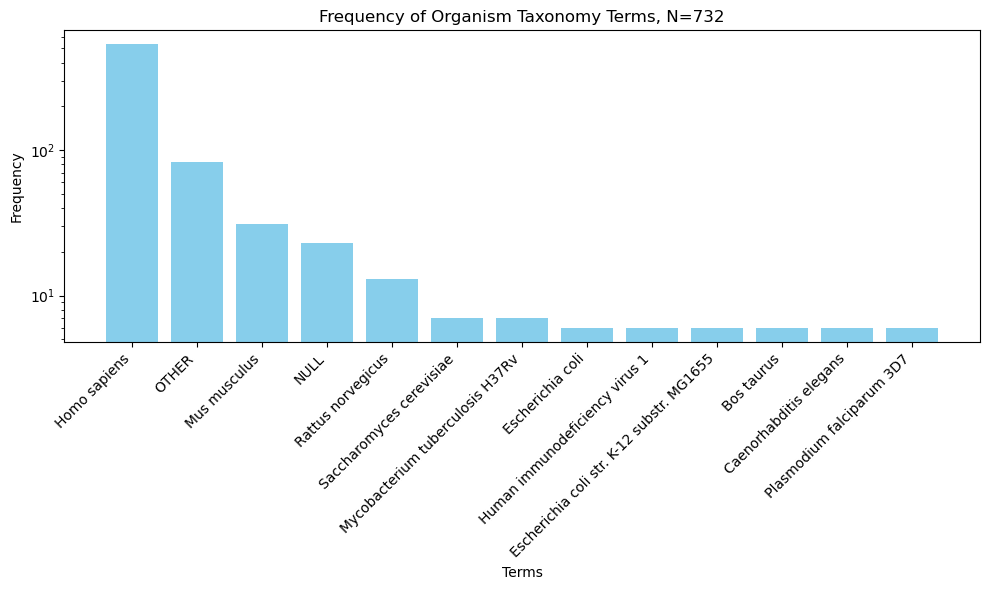

In [25]:
plot_term_counts(taxname_high_freq, "Organism Taxonomy")